In [1]:
import pandas as pd
import numpy as np
import pyecharts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
data = pd.read_csv('./global.csv').iloc[:,:12]
data_italy=data[data['countryEnglishName']=='Italy']
data_italy = data_italy[['countryEnglishName','province_confirmedCount','province_curedCount','province_deadCount','updateTime']]
#由于累积确诊人数随时间单向递增，按累计确诊人数对数据升序排列
data_italy.sort_values('province_confirmedCount',inplace=True)
#时间数据只保留month/day
for i in range(len(data_italy)):
    data_italy.iloc[i,4] = data_italy.iloc[i,4].split(' ')[0].split('-',1)[1]
#对每日数据只保留累计人数最大值
data_italy_agg=data_italy.groupby('updateTime').agg(np.max)
#加入每日新增确诊人数数据
data_italy_agg['daily_confirmed']=0
for i in range(len(data_italy_agg)-1):
        data_italy_agg.iloc[i+1,4]=data_italy_agg.iloc[i+1,1]-data_italy_agg.iloc[i,1]

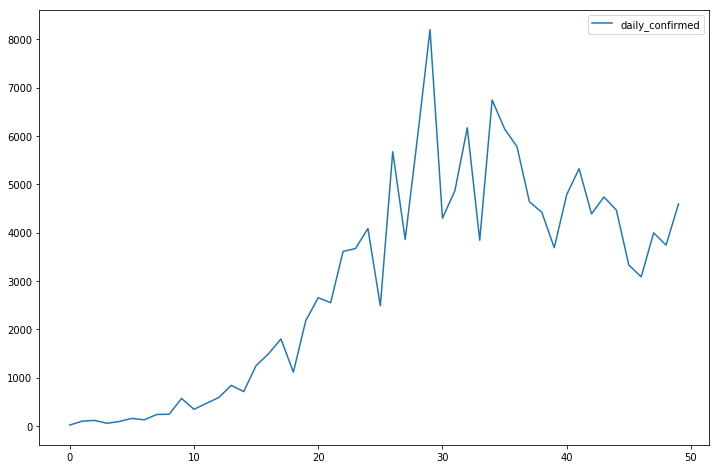

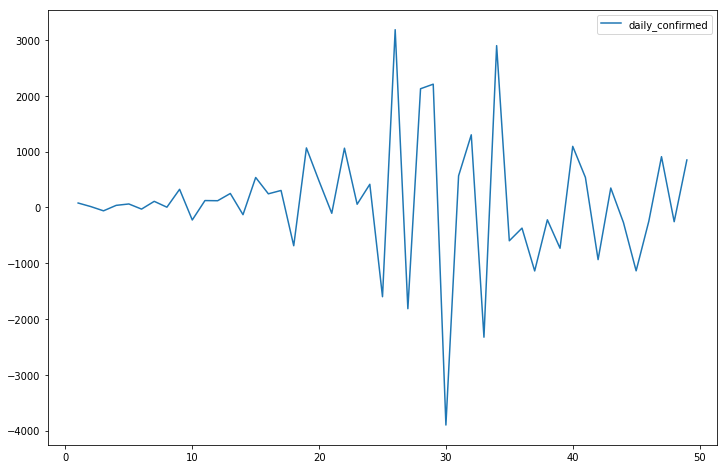

In [2]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
data_italy_agg = data_italy_agg.loc['02-22':,:]    #去除前期不明显的数据
data_italy_daily = data_italy_agg[['daily_confirmed']].reset_index(drop=True)

#数据类型转为浮点型
data_italy_daily['daily_confirmed']=data_italy_daily['daily_confirmed'].astype('float')
data_italy_daily.plot(figsize=(12,8))
#1阶差分后序列已经平稳,可以考虑ARIMA模型拟合
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = data_italy_daily.diff(1).iloc[1:,:]    #将第一行一阶差分后为NAN的数据去除
diff1.plot(ax=ax1)

C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


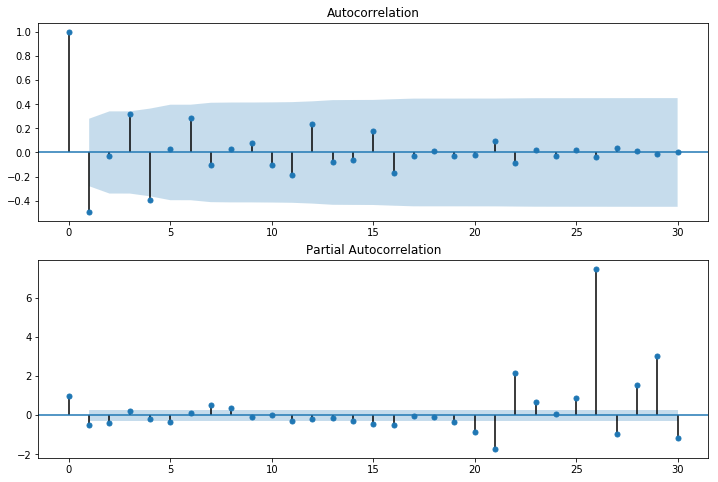

In [3]:
#参数估计，通过自相关图和偏自相关图寻找合适的p\q
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(diff1,lags=30,ax=ax1) #30阶滞后
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(diff1,lags=30,ax=ax2) #30阶滞后
#观察两图得知：自相关图4阶截尾，偏自相关图在滞后21阶后偏自相关图超出置信边界

In [5]:
#模型选择，根据上图备选模型有
#ARMA（0，3）--q=3的移动平均模型,ARMA（0，4）--q=4的移动平均模型，
#根据AIC\BIC\HQ准则选取模型
arma_mod03=sm.tsa.ARMA(diff1,(0,3)).fit()
print(arma_mod03.aic,arma_mod03.bic,arma_mod03.hqic)
arma_mod04=sm.tsa.ARMA(diff1,(0,4)).fit()
print(arma_mod04.aic,arma_mod04.bic,arma_mod04.hqic)
#根据三种准则选择ARMA（0，4）

823.8921012027475 833.3512026933007 827.4808711141297
817.3727538500693 828.7236756387331 821.679277743728


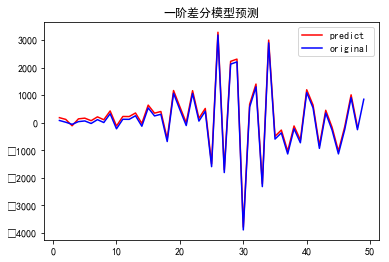

In [6]:
#模型预测
predict = arma_mod04.predict(0,53,dynamic=True)  #动态模型预测
#一阶差分还原
diff_shift_ts=diff1.shift(1)
diff_recover_1 = predict.add(diff_shift_ts['daily_confirmed'])
result=pd.DataFrame(diff_recover_1,columns=['predict'])
result['daily_confirm']=diff1
result['predict']=result['predict'].shift(-1)   #差分还原

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.title('一阶差分模型预测')
result['predict'].plot(color='red',label='predict')
result['daily_confirm'].plot(color='blue',label='original')
plt.legend()
plt.show()
#模型与实际差分情况拟合度较好，可以用来预测

In [21]:
result

,predict,daily_confirm
1,181.979958,80.0
2,118.872586,16.0
3,-111.934017,-60.0
4,139.334506,38.0
5,164.334506,63.0
6,72.334506,-29.0
7,211.334506,110.0
8,106.334506,5.0
9,427.334506,326.0
10,-122.665494,-224.0


In [19]:
#根据拟合效果进一步预测之后两天数据
predict_future = pd.DataFrame(arma_mod04.predict(49,53,dynamic=True),columns=['predict'])  #动态模型预测
predict_future['predict']=predict_future['predict'].shift(-1)   #差分还原
predict_future=predict_future.iloc[:2,:]
#根据拟合结果，4-12每日确诊数比4-11多101例，4-13每日确诊数比4-12多102例

In [20]:
predict_future

,predict
50,101.979958
51,102.872586


In [23]:
predict50=predict_future.loc[50,'predict']+data_italy_daily.loc[49,'daily_confirmed']
predict51=predict50+predict_future.loc[51,'predict']
predict_future.loc[50,'predict']=predict50
predict_future.loc[51,'predict']=predict51
predict_future.columns=['daily_confirmed']
outline=pd.concat([data_italy_daily,predict_future],axis=0)
outline#预测结果：4-12每日确诊9386例，4-1每日确诊9489例

,daily_confirmed
0,17.000000
1,97.000000
2,113.000000
3,53.000000
4,91.000000
5,154.000000
6,125.000000
7,235.000000
8,240.000000
9,566.000000


In [25]:
#为了进行时间序列分析重新读取数据
data = pd.read_csv('./global.csv').iloc[:,:12]
data_italy=data[data['countryEnglishName']=='Italy']
data_italy = data_italy[['countryEnglishName','province_confirmedCount','province_curedCount','province_deadCount','updateTime']]
data_italy.sort_values('province_confirmedCount',inplace=True)

#时间数据只保留year/month/day
for i in range(len(data_italy)):
    data_italy.iloc[i,4] = data_italy.iloc[i,4].split(' ')[0]
data_italy_agg=data_italy.groupby('updateTime').agg(np.max)

#趋势性数据研究和预测，为了进行时间序列分析需要先将index转换成DatetimeIndex
from datetime import datetime
def str2datetime(time):
    time_list=[]
    for item in time.split('-'):
        time_list.append(int(item))
    return datetime(time_list[0],time_list[1],time_list[2])

#对每日数据只保留累计人数最大值
data_italy_agg.reset_index(inplace=True)
data_italy_agg.updateTime=data_italy_agg.updateTime.apply(str2datetime)
data_italy_agg=data_italy_agg.groupby('updateTime').agg(np.max)    #还原df，索引已变为dateyimeindex

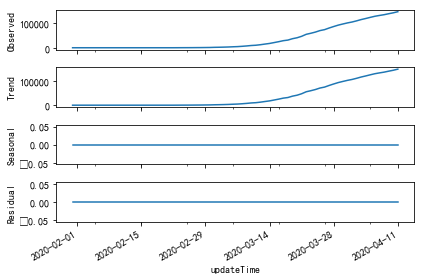

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
italy_confirm = data_italy_agg[['province_confirmedCount']]
decomposition = seasonal_decompose(italy_confirm,freq=1).plot()#分离趋势，指定时序序列为1否则无法找到DatetimeIndex
plt.show()
#通过时间序列季节模型提取趋势，发现累计确诊数只能提取出指数上升的趋势属性，季节属性和残差属性为0稳定，说明该指标只包括趋势属性。

In [27]:
#采用Holt指数平滑法预测未来累计确诊人数
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error
series_confirm = pd.Series(italy_confirm.province_confirmedCount)

#使用Hlot线性模型预测未来10天的发展情况
def Holt_fit(series,alpha,beta):
    fit = Holt(series).fit(smoothing_level=alpha,smoothing_slope=beta,optimized=False)
    return fit.fittedvalues,fit.forecast(10)

#使用Holt指数模型预测未来10天发展情况
def Holt_exp(series,alpha,beta):
    fit = Holt(series,exponential=True).fit(smoothing_level=alpha,smoothing_slope=beta,optimized=False)
    return fit.fittedvalues,fit.forecast(10)
#模型1：水平平滑参数0.8，趋势平滑参数0.2
fitvalue1,forcast1=Holt_fit(series_confirm,0.8,0.2)
#模型2：水平平滑参数0.5，趋势平滑参数0.5
fitvalue2,forcast2=Holt_fit(series_confirm,0.5,0.5)
#模型3：水平平滑参数0.8，趋势平滑参数0.2
fitvalue3,forcast3=Holt_exp(series_confirm,0.8,0.2)
#模型4：水平平滑参数0.5，趋势平滑参数0.5
fitvalue4,forcast4=Holt_exp(series_confirm,0.5,0.5)

#通过均方根误差检查模型准确性
print('模型1RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue3))
print('模型4RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue4))
#从RMSE角度来看，模型2拟合效果最好

模型1RMSE：
1420381.8046548434
模型2RMSE：
1147820.3011535523
模型3RMSE：
5337462.889131862
模型4RMSE：
2772594.2893187734


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\U

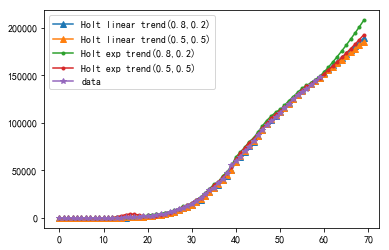

In [28]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='^')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(list(fitvalue4)+list(forcast4),marker='.')
l5 = plt.plot(series_confirm.values,marker='*')
plt.legend(labels=['Holt linear trend(0.8,0.2)','Holt linear trend(0.5,0.5)','Holt exp trend(0.8,0.2)','Holt exp trend(0.5,0.5)','data'],loc='best')
plt.show() 

In [30]:
print(forcast2)
#模型2认为，意大利累计确诊在4-12将达到151566例，4-13达到 155358例，4-14达到159150例，4-21达到185694例
fit_confirm,predict_confirm=fitvalue2,forcast2

60    151566.473447
61    155358.522501
62    159150.571556
63    162942.620611
64    166734.669666
65    170526.718721
66    174318.767775
67    178110.816830
68    181902.865885
69    185694.914940
dtype: float64


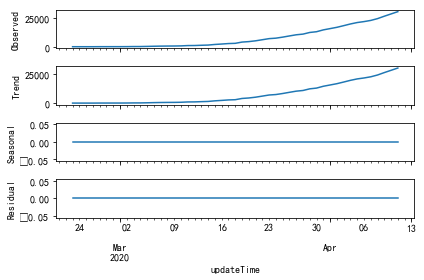

In [34]:
#累计治愈数时间序列分析
italy_cure=data_italy_agg[['province_curedCount']].iloc[11:,:]    #只保留统计数据非零部分
decomposition = seasonal_decompose(italy_cure,freq=1).plot()#分离趋势，指定时序序列为1否则无法找到DatetimeIndex
plt.show()

In [35]:
#采用Holt指数平滑预测未来累计治愈人数
series_cure = pd.Series(italy_cure.province_curedCount)

fitvalue1,forcast1=Holt_fit(series_cure,0.4,0.6)
fitvalue2,forcast2=Holt_fit(series_cure,0.3,0.7)
fitvalue3,forcast3=Holt_exp(series_cure,0.5,0.1)
fitvalue4,forcast4=Holt_exp(series_cure,0.5,0.2)

#通过均方根误差检查模型准确性
print('模型1RMSE：')
print(mean_squared_error(series_cure.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_cure.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_cure.values,fitvalue3))
print('模型4RMSE：')
print(mean_squared_error(series_cure.values,fitvalue4))
#模型1和模型2在均方根误差上表现较好

模型1RMSE：
131855.44986273642
模型2RMSE：
152270.58516222765
模型3RMSE：
3556290.426852878
模型4RMSE：
347971.87573422235


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


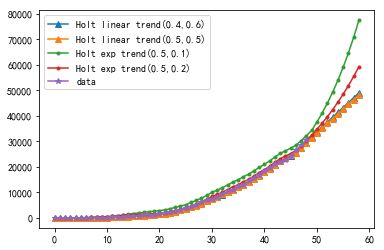

In [36]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='^')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(list(fitvalue4)+list(forcast4),marker='.')
l5 = plt.plot(series_cure.values,marker='*')
plt.legend(labels=['Holt linear trend(0.4,0.6)','Holt linear trend(0.5,0.5)','Holt exp trend(0.5,0.1)','Holt exp trend(0.5,0.2)',
                 'data'],loc='best')
plt.show() 

In [38]:
print(forcast1)
print(forcast2)
#模型1认为，意大利累计治愈在4-12将达到31763例，4-13达到 33684例，4-14达到35604例，4-21达到49048例
#模型2认为，意大利累计治愈在4-12将达到31451例，4-13达到 33321例，4-14达到35192例，4-21达到48284例
fit_cure,predict_cure=fitvalue1,forcast1

2020-04-12    31763.526269
2020-04-13    33684.133395
2020-04-14    35604.740521
2020-04-15    37525.347648
2020-04-16    39445.954774
2020-04-17    41366.561900
2020-04-18    43287.169027
2020-04-19    45207.776153
2020-04-20    47128.383279
2020-04-21    49048.990406
Freq: D, dtype: float64
2020-04-12    31451.583412
2020-04-13    33321.915342
2020-04-14    35192.247272
2020-04-15    37062.579201
2020-04-16    38932.911131
2020-04-17    40803.243061
2020-04-18    42673.574991
2020-04-19    44543.906921
2020-04-20    46414.238851
2020-04-21    48284.570781
Freq: D, dtype: float64


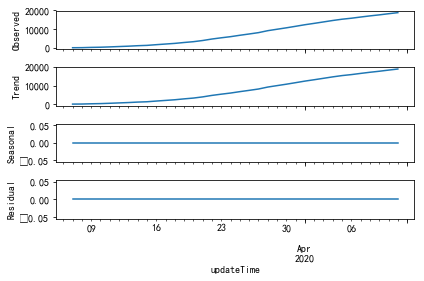

In [40]:
#累计死亡数时间序列分析
italy_death=data_italy_agg[['province_deadCount']].iloc[24:,:]
decomposition = seasonal_decompose(italy_death,freq=1).plot()   #分离趋势
plt.show()

In [41]:
#同上，直接采用Holt指数平滑
series_dead = pd.Series(italy_death.province_deadCount)
fitvalue1,forcast1=Holt_exp(series_dead,0.25,0.55)
fitvalue2,forcast2=Holt_fit(series_dead,0.4,0.6)
fitvalue3,forcast3=Holt_exp(series_dead,0.5,0.5)
print('模型1RMSE：')
print(mean_squared_error(series_dead.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_dead.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_dead.values,fitvalue3))
#根据均方根误差，模型2拟合效果较好

模型1RMSE：
204008.37270867126
模型2RMSE：
27311.577440664634
模型3RMSE：
57089.436350168995


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


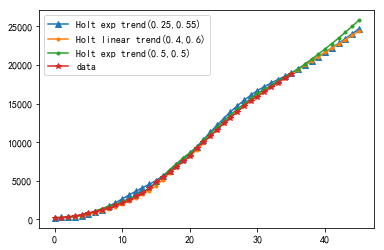

In [42]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='.')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(series_dead.values,marker='*')
plt.legend(labels=['Holt exp trend(0.25,0.55)','Holt linear trend(0.4,0.6)','Holt exp trend(0.5,0.5)','data'],loc='best')
plt.show() 

In [43]:
print(forcast2)
#模型2认为，意大利累计死亡在4-12将达到19398例，4-13达到19951例，4-14达到20505例，4-21达到 24380例
#疫情爆发初期无法控制,死亡人数野蛮增长，Holt指数模型更能从死亡人数上刻画疫情严重。
#后期随着防疫开展，疫情将逐渐得到控制，增速放缓，更适合用Holt加法模型，因此不同阶段的时间序列需要分段预测。
fit_dead,predict_dead=fitvalue2,forcast2

2020-04-12    19398.298470
2020-04-13    19951.897429
2020-04-14    20505.496387
2020-04-15    21059.095345
2020-04-16    21612.694303
2020-04-17    22166.293261
2020-04-18    22719.892219
2020-04-19    23273.491177
2020-04-20    23827.090135
2020-04-21    24380.689093
Freq: D, dtype: float64


In [44]:
#预测结果汇总输出
result=pd.DataFrame(fit_confirm,columns=['province_confirmedCount'])

fit_cure=fit_cure.values.tolist()
result['province_cureCount']=0
for i in range(len(fit_cure)):
    result.iloc[16+i:,1]=fit_cure[i]
    
fit_dead=fit_dead.values.tolist()
result['province_deadCount']=0
for i in range(len(fit_dead)):
    result.iloc[24+i:,2]=fit_dead[i]
    
forcast=pd.DataFrame(predict_dead,columns=['province_deadCount'])
forcast['province_cureCount']=0
forcast['province_confirmedCount']=0
predict_cure=predict_cure.values.tolist()
predict_confirm=predict_confirm.values.tolist()

forcast['province_cureCount']=predict_cure
forcast['province_confirmedCount']=predict_confirm
result = pd.concat([result,forcast],axis=0)

C:\Users\Ricardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [45]:
result

,province_confirmedCount,province_cureCount,province_deadCount
2020-01-31,2.000000,0.000000,0.000000
2020-02-01,2.000000,0.000000,0.000000
2020-02-08,2.000000,0.000000,0.000000
2020-02-10,2.750000,0.000000,0.000000
2020-02-11,3.187500,0.000000,0.000000
2020-02-12,3.359375,0.000000,0.000000
2020-02-13,3.355469,0.000000,0.000000
2020-02-14,3.264648,0.000000,0.000000
2020-02-15,3.153076,0.000000,0.000000
2020-02-16,3.059021,0.000000,0.000000


In [51]:
#最后拼接上ARIMA模型预测的每日确诊情况
fit_daily=outline['daily_confirmed'].values
result['province_dailyConfirm']=0
for i in range(len(fit_daily)):
    result.iloc[i+18,3]=fit_daily[i]

In [53]:
result.to_csv('./意大利疫情预测.csv')